# Transfer Learning Part 3: Scaling Up

In [1]:
# Check if using a GPU
!nvidia-smi

Fri Jan 27 00:38:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper Functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-27 00:38:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-27 00:38:26 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Importing a series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves
from helper_functions import unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with Less Data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2023-01-27 00:38:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  41.5MB/s    in 39s     

2023-01-27 00:39:10 (39.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Setup dirs
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [6]:
# How many images/classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 

In [7]:
import tensorflow as tf

In [8]:
# Setup data inputs
IMG_SHAPE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a Big Model with Transfer Learning on 10% of 101 Food Classes

In [9]:
# Create a checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [10]:
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential

In [11]:
# Create data augmentation layer to incorporate it into the model
# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [12]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with training top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), 
                       activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [13]:
# Get a summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
# Compile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 327ms/step - loss: 3.3715 - accuracy: 0.2800 - val_loss: 2.5665 - val_accuracy: 0.4256
Epoch 2/5
237/237 [==============================] - 64s 268ms/step - loss: 2.2037 - accuracy: 0.5002 - val_loss: 2.0843 - val_accuracy: 0.4981
Epoch 3/5
237/237 [==============================] - 60s 254ms/step - loss: 1.8162 - accuracy: 0.5684 - val_loss: 1.9242 - val_accuracy: 0.5233
Epoch 4/5
237/237 [==============================] - 55s 231ms/step - loss: 1.6105 - accuracy: 0.6102 - val_loss: 1.8185 - val_accuracy: 0.5379
Epoch 5/5
237/237 [==============================] - 53s 219ms/step - loss: 1.4567 - accuracy: 0.6405 - val_loss: 1.7934 - val_accuracy: 0.5331


In [15]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 59s 75ms/step - loss: 1.5788 - accuracy: 0.5869


[1.5787502527236938, 0.5869306921958923]

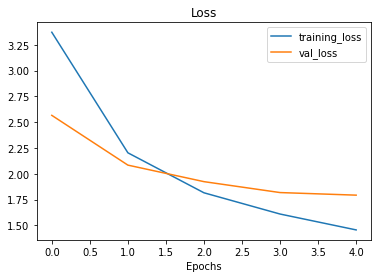

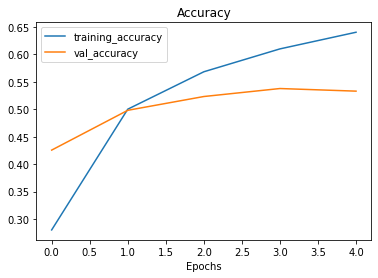

In [16]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-tuning

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [18]:
# Recompile the model with lower learning rate (best pratice)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [19]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check which layers are trainable in the base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [21]:
# Fine-tune for 5 more epochs
# The model already has 5 epochs
fine_tune_epochs = 10

# Fine-tune the model
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1]
    )

Epoch 5/10
237/237 [==============================] - 58s 216ms/step - loss: 1.2154 - accuracy: 0.6813 - val_loss: 1.7588 - val_accuracy: 0.5384
Epoch 6/10
237/237 [==============================] - 49s 205ms/step - loss: 1.0950 - accuracy: 0.7052 - val_loss: 1.7414 - val_accuracy: 0.5493
Epoch 7/10
237/237 [==============================] - 46s 193ms/step - loss: 1.0180 - accuracy: 0.7237 - val_loss: 1.7014 - val_accuracy: 0.5548
Epoch 8/10
237/237 [==============================] - 44s 185ms/step - loss: 0.9465 - accuracy: 0.7461 - val_loss: 1.7559 - val_accuracy: 0.5442
Epoch 9/10
237/237 [==============================] - 43s 179ms/step - loss: 0.8906 - accuracy: 0.7625 - val_loss: 1.7228 - val_accuracy: 0.5530
Epoch 10/10
237/237 [==============================] - 44s 182ms/step - loss: 0.8334 - accuracy: 0.7748 - val_loss: 1.7432 - val_accuracy: 0.5490


In [22]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 56s 71ms/step - loss: 1.4969 - accuracy: 0.6027


[1.496854305267334, 0.6026930809020996]

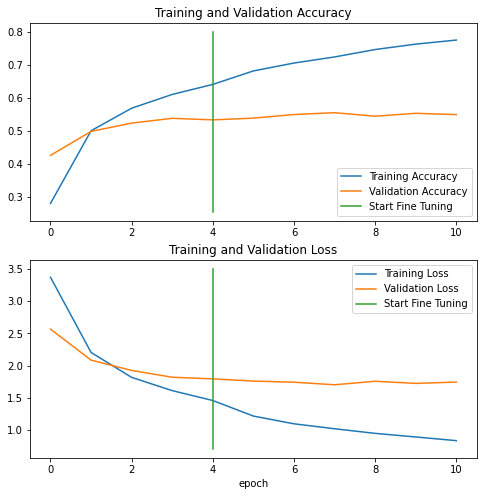

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(
    original_history=history_all_classes_10_percent,
    new_history=history_all_classes_10_percent_fine_tune,
    initial_epochs=5
    )

## Saving and Loading a Model

In [24]:
# Save the fine-tuned model
model.save('101_food_classes_10_percent_model')

In [25]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model('101_food_classes_10_percent_model')

In [26]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 61s 75ms/step - loss: 1.4969 - accuracy: 0.6027


[1.496854305267334, 0.6026930809020996]

In [27]:
# The results from the loaded model above should be very similar 
# to the results below
all_classes_10_percent_fine_tune_results

[1.496854305267334, 0.6026930809020996]

## Evaluating the Performance of the Big Model Across all Diferent Classes

### Making Predictions

In [28]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 60s 74ms/step


In [29]:
len(test_data)

790

In [30]:
print(f'790 Images per 32 batches = {790 * 32} Images')

790 Images per 32 batches = 25280 Images


In [31]:
# How many predictions are there?
len(preds_probs)

25250

In [32]:
# First 10 predictions
preds_probs[:10]

array([[1.3234907e-01, 1.3271447e-04, 1.0188128e-01, ..., 2.4281462e-05,
        6.4644907e-03, 1.7895253e-02],
       [8.6844748e-01, 6.0523092e-08, 8.7593513e-04, ..., 9.4765108e-03,
        1.7129553e-07, 6.8329587e-06],
       [3.5552865e-01, 1.7303158e-02, 4.8401151e-02, ..., 4.4647983e-04,
        3.8511326e-04, 4.6755336e-03],
       ...,
       [1.7061064e-01, 3.6145293e-06, 8.7634061e-04, ..., 1.4659391e-01,
        6.1297056e-04, 7.2375224e-05],
       [6.4871587e-02, 2.2417688e-04, 5.4061735e-01, ..., 2.6459826e-04,
        1.5994758e-04, 1.9578730e-04],
       [7.1780992e-01, 2.7856527e-07, 2.7728190e-03, ..., 3.9060544e-03,
        1.0864477e-06, 4.5985129e-04]], dtype=float32)

In [33]:
# What does the first prediction probability array looks like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.32349074e-01, 1.32714471e-04, 1.01881281e-01, 1.19928401e-07,
        9.68031600e-06, 1.20214963e-06, 2.76472274e-05, 2.24871451e-06,
        1.71183124e-02, 1.85617726e-04, 9.47332467e-07, 1.03060784e-05,
        5.11376187e-04, 6.53179939e-07, 3.10739013e-03, 9.41882492e-04,
        4.32896049e-05, 1.78797380e-03, 3.90453846e-03, 3.08615381e-05,
        5.52370853e-04, 6.32159754e-06, 5.14979183e-04, 4.77990179e-05,
        2.98583385e-04, 2.86077056e-03, 2.62827292e-04, 4.73051659e-05,
        2.35985905e-01, 9.06652538e-04, 5.65766868e-06, 7.70680723e-04,
        1.79752518e-04, 4.13732479e-08, 1.37795666e-02, 1.65379936e-06,
        1.26267521e-04, 2.20938865e-03, 1.10731766e-01, 1.17077332e-04,
        2.85232119e-04, 1.56320771e-03, 2.91976728e-04, 7.23436415e-06,
        1.45613420e-04, 1.52888824e-05, 2.97903176e-03, 1.96866196e-04,
        4.50844794e-07, 9.81736556e-02, 1.08110034e-04, 6.28253474e-05,
        5.90574741e-02, 9.05464031e-03, 3.86451575e-05, 4.801816

- The model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

- There is one prediction probability per class (in this case, there's 101 prediction probabilities)

In [34]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f'What prediction probability sample 0 looks like: \n {preds_probs[0]}')
print(f'The class with the highest predicted probability by the \
model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: 
 [1.32349074e-01 1.32714471e-04 1.01881281e-01 1.19928401e-07
 9.68031600e-06 1.20214963e-06 2.76472274e-05 2.24871451e-06
 1.71183124e-02 1.85617726e-04 9.47332467e-07 1.03060784e-05
 5.11376187e-04 6.53179939e-07 3.10739013e-03 9.41882492e-04
 4.32896049e-05 1.78797380e-03 3.90453846e-03 3.08615381e-05
 5.52370853e-04 6.32159754e-06 5.14979183e-04 4.77990179e-05
 2.98583385e-04 2.86077056e-03 2.62827292e-04 4.73051659e-05
 2.35985905e-01 9.06652538e-04 5.65766868e-06 7.70680723e-04
 1.79752518e-04 4.13732479e-08 1.37795666e-02 1.65379936e-06
 1.26267521e-04 2.20938865e-03 1.10731766e-01 1.17077332e-04
 2.85232119e-04 1.56320771e-03 2.91976728e-04 7.23436415e-06
 1.45613420e-04 1.52888824e-05 2.97903176e-03 1.96866196e-04
 4.50844794e-07 9.81736556e-02 1.08110034e-04 6.28253474e-05
 5.90574741e-02 9.05464031e-03 3.86451575e-05 4.80181677e-03
 6.12081550e-02 4.50784434e-03 4.01637843e

In [35]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([28,  0,  0,  8,  8, 78, 29, 46,  2,  0])

In [36]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [37]:
# To get the test labels, the test data (BatchDataset) will need to be unravel
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Evaluating the Model's Predictions

In [38]:
all_classes_10_percent_fine_tune_results

[1.496854305267334, 0.6026930809020996]

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
# Trying Scikit-learn's accuracy score function
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6026930693069307

In [41]:
import numpy as np

In [42]:
# Does this metric come close to the model's evaluated results?
np.isclose(all_classes_10_percent_fine_tune_results[1], sklearn_accuracy)

True

### Visualizing

In [43]:
from sklearn.metrics import classification_report

In [44]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,
                                                   pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.38613861386138615,
  'recall': 0.156,
  'f1-score': 0.2222222222222222,
  'support': 250},
 '1': {'precision': 0.584717607973422,
  'recall': 0.704,
  'f1-score': 0.6388384754990927,
  'support': 250},
 '2': {'precision': 0.6197718631178707,
  'recall': 0.652,
  'f1-score': 0.6354775828460039,
  'support': 250},
 '3': {'precision': 0.8723404255319149,
  'recall': 0.492,
  'f1-score': 0.6291560102301791,
  'support': 250},
 '4': {'precision': 0.5483870967741935,
  'recall': 0.408,
  'f1-score': 0.46788990825688076,
  'support': 250},
 '5': {'precision': 0.5379746835443038,
  'recall': 0.34,
  'f1-score': 0.41666666666666663,
  'support': 250},
 '6': {'precision': 0.8194444444444444,
  'recall': 0.708,
  'f1-score': 0.7596566523605149,
  'support': 250},
 '7': {'precision': 0.834061135371179,
  'recall': 0.764,
  'f1-score': 0.7974947807933194,
  'support': 250},
 '8': {'precision': 0.22530864197530864,
  'recall': 0.584,
  'f1-score': 0.32516703786191536,
  'suppor

In [45]:
class_names = test_data.class_names
class_names[:3]

['apple_pie', 'baby_back_ribs', 'baklava']

In [46]:
classification_report_dict['0']['f1-score']

0.2222222222222222

In [47]:
# Create an empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == 'accuracy':     # Stop once it gets to accuracy key
        break
    else:
        # Add class names and f1-score to new dictionary
        class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.2222222222222222,
 'baby_back_ribs': 0.6388384754990927,
 'baklava': 0.6354775828460039,
 'beef_carpaccio': 0.6291560102301791,
 'beef_tartare': 0.46788990825688076,
 'beet_salad': 0.41666666666666663,
 'beignets': 0.7596566523605149,
 'bibimbap': 0.7974947807933194,
 'bread_pudding': 0.32516703786191536,
 'breakfast_burrito': 0.5166402535657685,
 'bruschetta': 0.47085201793721965,
 'caesar_salad': 0.6848739495798319,
 'cannoli': 0.6398467432950192,
 'caprese_salad': 0.5703564727954973,
 'carrot_cake': 0.5419664268585132,
 'ceviche': 0.37711864406779666,
 'cheese_plate': 0.597752808988764,
 'cheesecake': 0.3958691910499139,
 'chicken_curry': 0.5100401606425702,
 'chicken_quesadilla': 0.6724137931034483,
 'chicken_wings': 0.7370600414078674,
 'chocolate_cake': 0.5491651205936919,
 'chocolate_mousse': 0.35699797160243407,
 'churros': 0.7221095334685598,
 'clam_chowder': 0.7091295116772823,
 'club_sandwich': 0.7008547008547009,
 'crab_cakes': 0.3696682464454977,
 'creme_br

In [48]:
import pandas as pd

In [49]:
# Turn f1-scores into dataframe
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}
                         ).sort_values('f1-score', ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.964567
63,macarons,0.885593
75,pho,0.840691
32,dumplings,0.840000
68,onion_rings,0.827451
...,...,...
93,steak,0.324952
50,grilled_salmon,0.318318
82,ravioli,0.316310
77,pork_chop,0.298289


In [50]:
import matplotlib.pyplot as plt

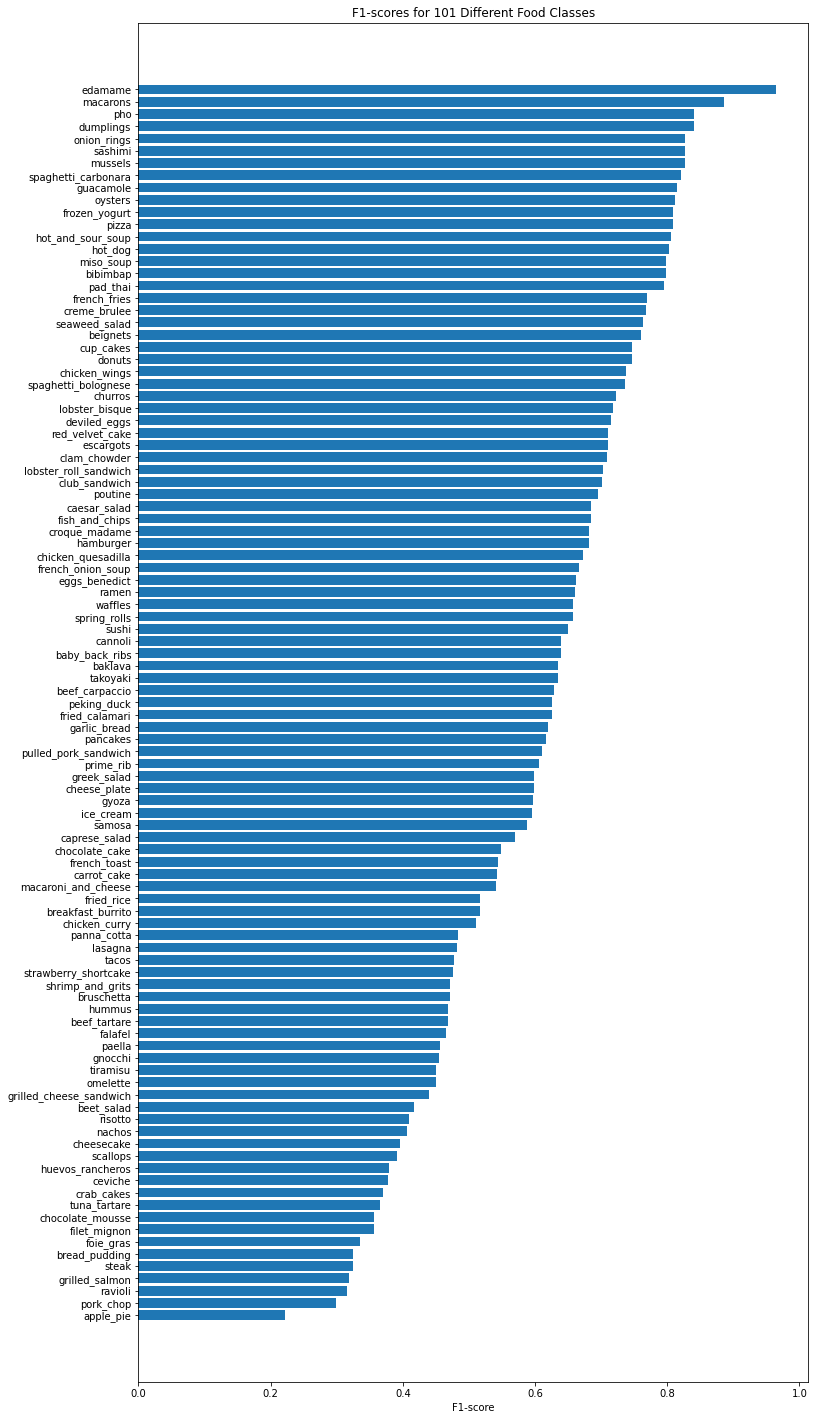

In [51]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names']);
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Different Food Classes')
ax.invert_yaxis()

## Visualizing Predictions on Test Images

In [52]:
# Create a function to load and prepare images
def load_and_prep_images(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes
    into specified shape (img_shape, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        img_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale? Yes/no
    if scale:
        # Rescale the image
        return img / 255.
    else:
        return img

In [53]:
import os
import random

1/1 [==============================] - 0s 22ms/step


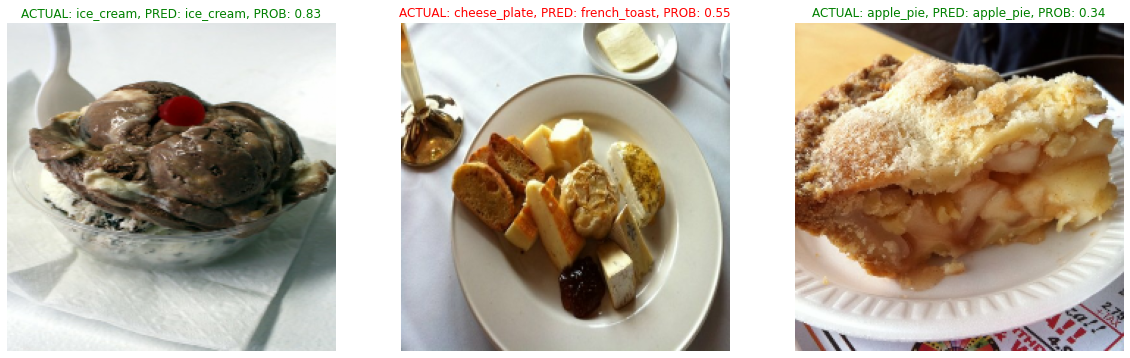

In [63]:
# Make predictions on a series of random images
plt.figure(figsize=(20, 10))
for i in range(3):
    # Choose random image(s) from a random class(es)
    random_class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + '/' + random_class_name))
    filepath = test_dir + '/' + random_class_name + '/' + filename
    # print(filename)
    # print(filepath)
    # Load the image and make predictions
    img = load_and_prep_images(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    # Get prediction probabilities array
    pred_prob = model.predict(img_expanded)
    # Get highest prediction probability index and match it to class_name list
    pred_class = class_names[pred_prob.argmax()]
    # print(pred_prob)
    # print(pred_class)

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img / 255.)
    # if predicted class matches truth class, makes text green
    if random_class_name == pred_class:
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f'ACTUAL: {random_class_name}, PRED: {pred_class}, PROB: {pred_prob.max():.2f}', c=title_color)
    plt.axis(False)

## Finding the Most Wrong Predictions

In [68]:
# 1. Get all the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files(
    '101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
    
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [69]:
# 2. Create a DataFrame of different parameters for each
# of the test images
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        # Get the maximum prediction probability value
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_classnames': [class_names[i] for i in y_labels],
                        'y_pred_classnames': [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classnames,y_pred_classnames
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,28,0.235986,apple_pie,croque_madame
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.868447,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.355529,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.262329,apple_pie,bread_pudding
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.607680,apple_pie,bread_pudding
...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.985191,waffles,waffles
25246,b'101_food_classes_10_percent/test/waffles/954...,100,16,0.793440,waffles,cheese_plate
25247,b'101_food_classes_10_percent/test/waffles/961...,100,100,0.462508,waffles,waffles
25248,b'101_food_classes_10_percent/test/waffles/970...,100,100,0.245402,waffles,waffles


In [70]:
# 3. Find out in the DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classnames,y_pred_classnames,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,28,0.235986,apple_pie,croque_madame,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.868447,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.355529,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.262329,apple_pie,bread_pudding,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.607680,apple_pie,bread_pudding,False


In [71]:
# 4. Sorting the DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values(
    'pred_conf',
    ascending=False,   
)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classnames,y_pred_classnames,pred_correct
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.998627,strawberry_shortcake,red_velvet_cake,False
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.998081,pancakes,omelette,False
11642,b'101_food_classes_10_percent/test/garlic_brea...,46,10,0.996990,garlic_bread,bruschetta,False
5829,b'101_food_classes_10_percent/test/churros/227...,23,68,0.996905,churros,onion_rings,False
7295,b'101_food_classes_10_percent/test/cup_cakes/1...,29,31,0.996883,cup_cakes,donuts,False
191,b'101_food_classes_10_percent/test/apple_pie/3...,0,31,0.996465,apple_pie,donuts,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.996408,fried_calamari,onion_rings,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.995734,paella,mussels,False
16271,b'101_food_classes_10_percent/test/mussels/140...,65,69,0.995349,mussels,oysters,False
8794,b'101_food_classes_10_percent/test/escargots/1...,35,41,0.994090,escargots,french_onion_soup,False


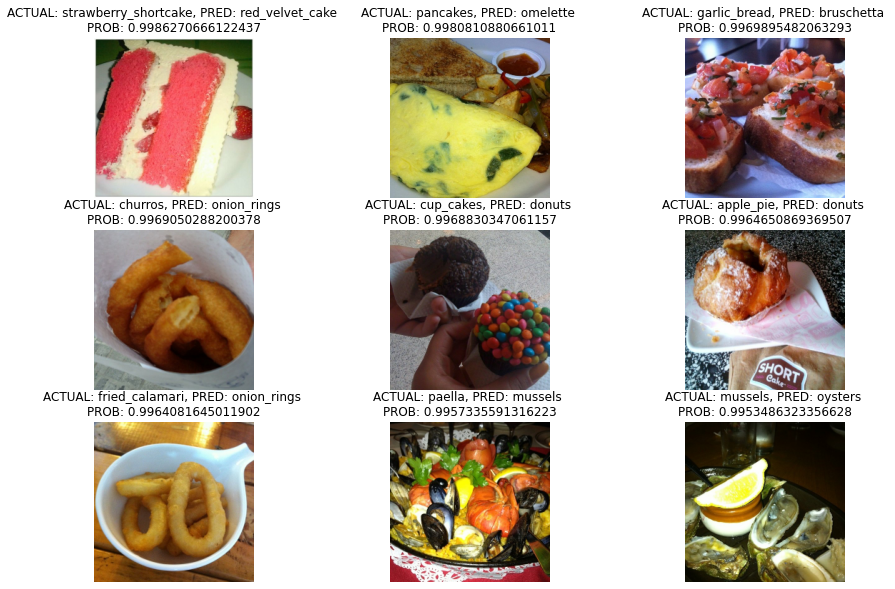

In [72]:
# 5. Visualize the test data samples which have the wrong
# prediction but highest prediction probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_images(row[1], scale=False)
    # Only interested in a few parameters of each row
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
    plt.imshow(img / 255.)
    plt.title(f'ACTUAL: {y_true_classname}, PRED: {y_pred_classname} \nPROB: {pred_prob}')
    plt.axis(False)

## Visualizing Predictions on Custom Images

In [73]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2023-01-27 02:31:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.251.31.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  13.4MB/s    in 0.9s    

2023-01-27 02:31:03 (13.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [75]:
# Get the custom food images filepaths
custom_food_images = [
    'custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')
    ]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 22ms/step


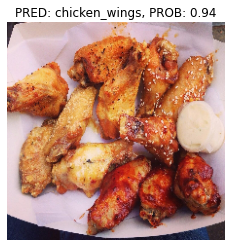

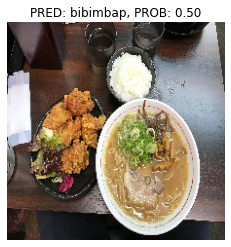

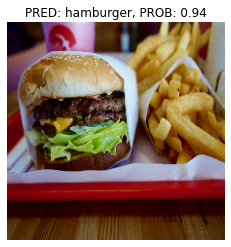

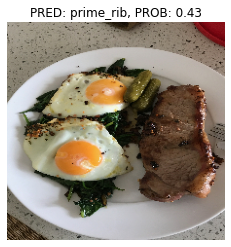

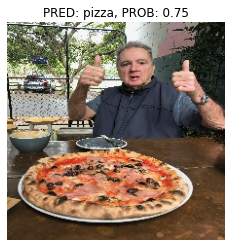

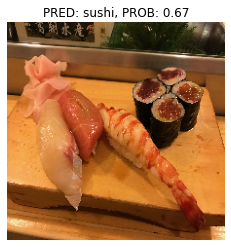

In [76]:
# Make predictions on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_images(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    # Plot the appropriate information
    plt.figure()
    plt.imshow(img / 255.)
    plt.title(f'PRED: {pred_class}, PROB: {pred_prob.max():.2f}')
    plt.axis(False)